In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import scipy.signal as signal
import scipy.integrate as integrate
from scipy.stats import entropy as signal_entropy
import pywt

In [2]:
ecg_data = pd.read_csv('data/TestECG.csv')
ecg_data.head()

,sampleNum,ECG
0,1,-1
1,2,-3208
2,3,-1370
3,4,-1417
4,5,-1874


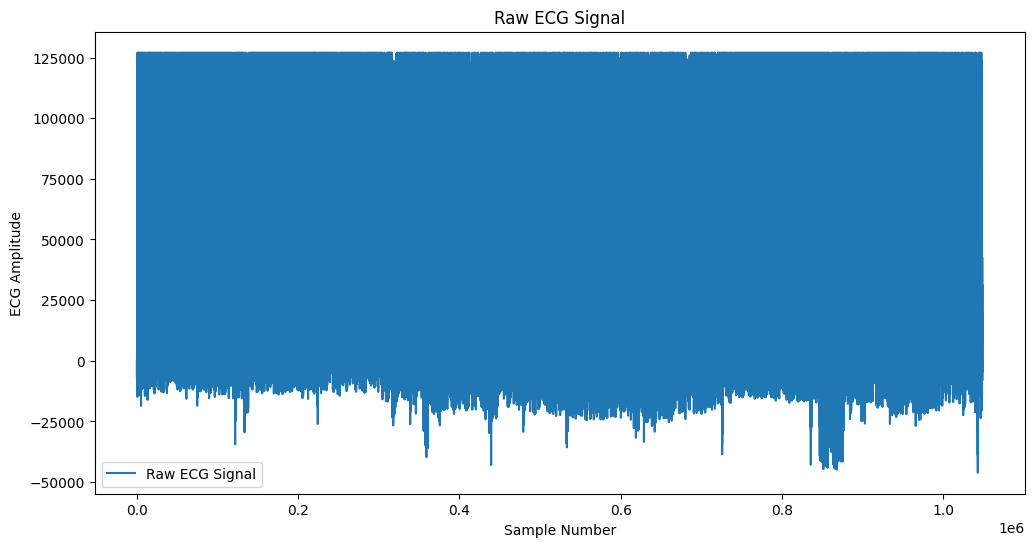

In [3]:
# Plot the raw ECG signal
plt.figure(figsize=(12, 6))
plt.plot(ecg_data['sampleNum'], ecg_data['ECG'], label='Raw ECG Signal')
plt.xlabel('Sample Number')
plt.ylabel('ECG Amplitude')
plt.title('Raw ECG Signal')
plt.legend()
plt.show()

In [4]:
fs = 1024
ecg = ecg_data['ECG']
time = ecg_data['sampleNum']

 # Notch filter to remove powerline noise at 50 Hz
nyquist = 0.5 * fs
notch_freq = 50 / nyquist
b_notch, a_notch = signal.iirnotch(notch_freq, 50 / 35)
ecg_notch = signal.filtfilt(b_notch, a_notch, ecg)

# Low-pass filter to remove high-frequency noise
low_cutoff = 40 / nyquist
b_lp, a_lp = signal.butter(6, low_cutoff, btype='low')
ecg_filtered = signal.filtfilt(b_lp, a_lp, ecg_notch)



In [5]:
# Define segment size (e.g., 5 seconds segments)
segment_size = 10 * fs
segments = ecg_filtered[:segment_size]
time = ecg_data['sampleNum']
time_segments = time[:segment_size]

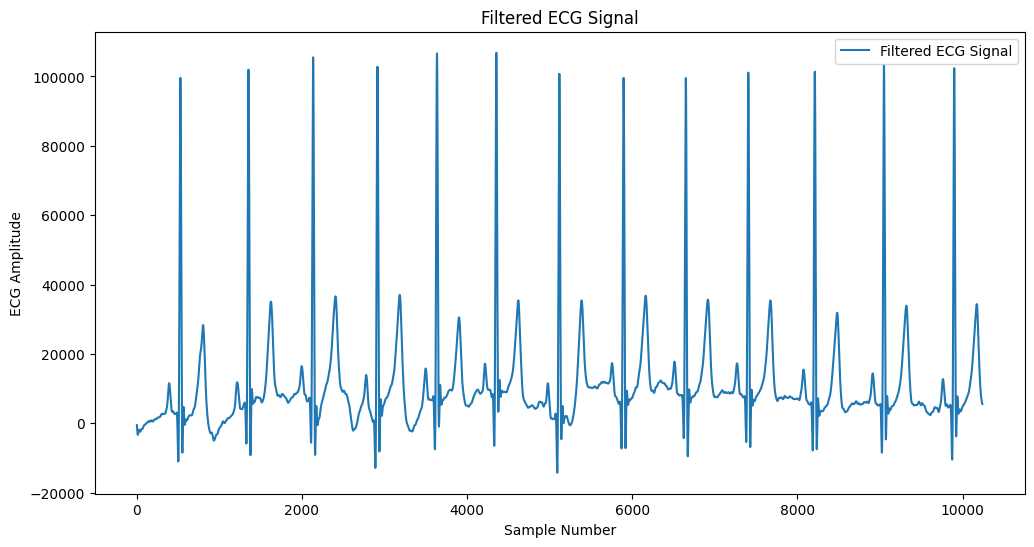

In [6]:
# Plot the filtered ECG signal
plt.figure(figsize=(12, 6))
plt.plot(time_segments, segments, label='Filtered ECG Signal')
plt.xlabel('Sample Number')
plt.ylabel('ECG Amplitude')
plt.title('Filtered ECG Signal')
plt.legend()
plt.show()

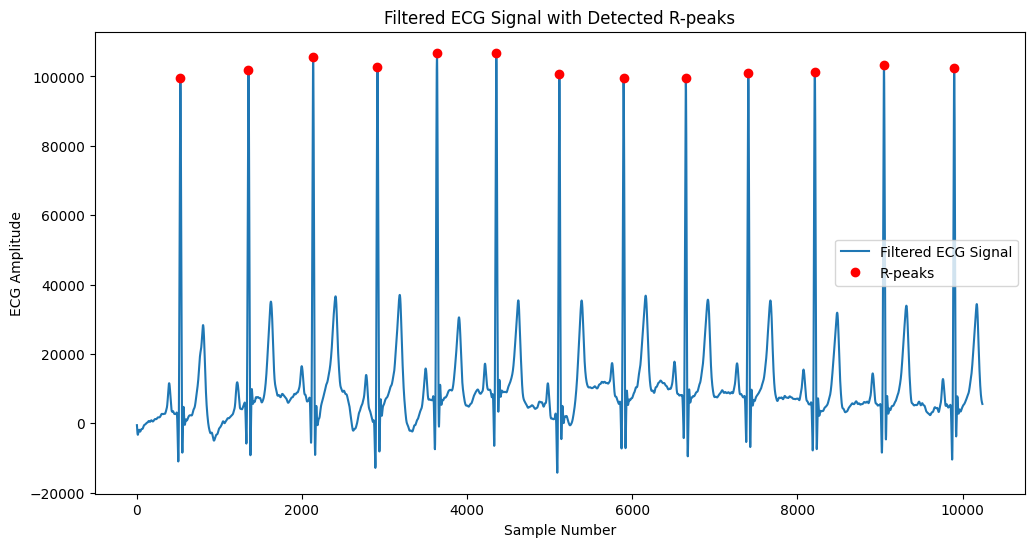

In [7]:
# Detect R-peaks using scipy's find_peaks
r_peaks, properties = signal.find_peaks(segments, distance=0.6*fs, height=np.mean(segments))

# Plot the filtered ECG signal with detected R-peaks
plt.figure(figsize=(12, 6))
plt.plot(time_segments, segments, label='Filtered ECG Signal')
plt.plot(r_peaks, segments[r_peaks], 'ro', label='R-peaks')
plt.xlabel('Sample Number')
plt.ylabel('ECG Amplitude')
plt.title('Filtered ECG Signal with Detected R-peaks')
plt.legend()
plt.show()


In [8]:
def find_q_s_points(ecg_signal, r_peaks, search_window=30):
    q_points = []
    s_points = []
    for r_peak in r_peaks:
        # Q point is the minimum point in the window before the R peak
        q_window = ecg_signal[max(0, r_peak - search_window):r_peak]
        q_point = max(0, r_peak - search_window) + np.argmin(q_window)
        q_points.append(q_point)
        
        # S point is the minimum point in the window after the R peak
        s_window = ecg_signal[r_peak:min(len(ecg_signal), r_peak + search_window)]
        s_point = r_peak + np.argmin(s_window)
        s_points.append(s_point)
        
    return np.array(q_points), np.array(s_points)

In [9]:
# Find Q and S points
q_points, s_points = find_q_s_points(segments, r_peaks)

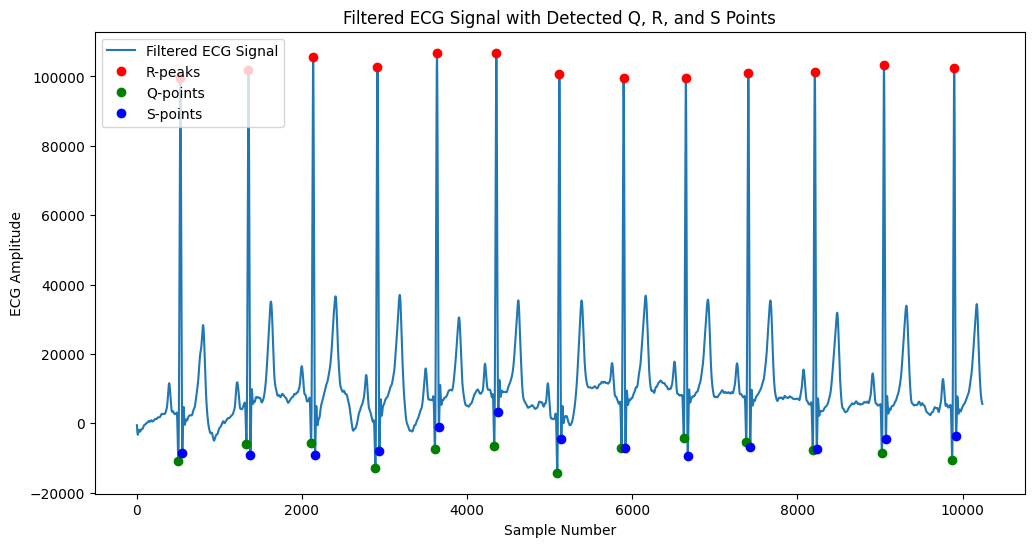

In [10]:
# Plot the filtered ECG signal with detected Q, R, and S points
plt.figure(figsize=(12, 6))
plt.plot(time_segments, segments, label='Filtered ECG Signal')
plt.plot(r_peaks, segments[r_peaks], 'ro', label='R-peaks')
plt.plot(q_points, segments[q_points], 'go', label='Q-points')
plt.plot(s_points, segments[s_points], 'bo', label='S-points')
plt.xlabel('Sample Number')
plt.ylabel('ECG Amplitude')
plt.title('Filtered ECG Signal with Detected Q, R, and S Points')
plt.legend()
plt.show()

In [11]:
# Extract features from each segments
def compute_power_in_band(segment, fs, band):
    f, Pxx = signal.welch(segment, fs=fs, nperseg=len(segment))
    band_indices = (f >= band[0]) & (f <= band[1])
    band_power = integrate.simpson(Pxx[band_indices], x=f[band_indices])
    return band_power
  
def extract_features(points, window_size, labels):  
  features = []
  for i, point in enumerate(points): 
    for x_point in point:
      start_idx = max(x_point - window_size//2, 0)
      end_idx = min(x_point + window_size//2, len(segments)) 
      segment = segments[start_idx:end_idx]
      label = labels[i]
      mean_val = np.mean(segment)
      std_val = np.std(segment)
      max_val = np.max(segment)
      min_val = np.min(segment)
      power_0_5Hz = compute_power_in_band(segment, fs, (0,5))
      power_5_15Hz = compute_power_in_band(segment, fs, (5, 15))
      power_15_40Hz = compute_power_in_band(segment, fs, (15, 40))
      entropy = signal_entropy(np.abs(segment))
      cwt_coeffs, _ = pywt.cwt(segment, scales=np.arange(1, 11), wavelet='morl', sampling_period=1/fs)
      wavelet_mean = np.mean(np.abs(cwt_coeffs), axis=1)
      feature_set = [label, mean_val, std_val, max_val, min_val, power_0_5Hz, power_5_15Hz, power_15_40Hz, entropy] + wavelet_mean.tolist()
      features.append(feature_set)
      
  return features
  
# extract features for r, q, s  
points = [r_peaks, q_points, s_points]
labels = ['R', 'Q', 'S']
window_size = int(0.2*fs)

features = extract_features(points, window_size, labels)
  
 

In [14]:
# Combine all features into a DataFrame
features_df = pd.DataFrame(features, columns=['label', 'mean', 'std', 'max', 'min', 'power_0_5Hz', 'power_5_15Hz', 'power_15_40Hz', 'entropy'] + [f'wavelet_{i}' for i in range(1, 11)])
features_df.to_csv('data/extracted_features.csv')
features_df

,label,mean,std,max,min,power_0_5Hz,power_5_15Hz,power_15_40Hz,entropy,wavelet_1,wavelet_2,wavelet_3,wavelet_4,wavelet_5,wavelet_6,wavelet_7,wavelet_8,wavelet_9,wavelet_10
0,R,10594.295690,25611.887072,99587.071215,-10993.031304,0.0,3.151840e+08,7.086607e+08,4.160905,49.384192,12.009197,30.465866,35.898418,80.185284,69.593555,137.867537,132.422100,208.962079,274.049349
1,R,13906.881968,25351.827266,101927.921089,-9194.956281,0.0,2.967220e+08,7.225974e+08,4.523962,53.763930,25.820123,52.785089,76.601175,137.638549,142.716845,233.362515,247.206745,345.504434,431.588023
2,R,13551.583116,26605.887167,105486.889267,-9110.283126,0.0,3.453184e+08,7.493882e+08,4.377426,56.437415,30.397432,60.533642,90.156707,157.623403,167.676424,265.929495,287.778466,394.669486,492.872202
3,R,11687.676097,26293.114735,102795.493357,-12853.216857,0.0,3.277630e+08,7.598311e+08,4.327987,54.875825,25.095538,52.062681,74.577640,135.759103,139.710806,230.212313,243.470145,343.009422,430.776661
4,R,15929.920581,26243.427851,106627.392709,-7469.152638,0.0,3.379108e+08,7.242026e+08,4.580889,55.523960,30.967439,61.115188,91.722810,159.219566,169.874734,268.465107,290.613594,397.148046,492.818232
5,R,17849.756350,25855.706210,106838.064003,-6486.758825,0.0,3.345343e+08,6.869767e+08,4.716631,57.154660,40.706582,76.519310,120.465875,199.032854,221.744044,333.879438,372.610869,492.557360,607.388919
6,R,10521.038009,26134.716049,100765.468695,-14240.213345,0.0,3.350465e+08,7.165165e+08,4.097310,47.725174,5.827524,20.409619,17.588324,54.471814,36.278425,95.312083,79.625397,147.613963,199.210508
7,R,14186.781661,24434.869408,99569.877747,-7248.708280,0.0,2.711344e+08,6.891181e+08,4.600316,55.282658,32.712317,63.799646,96.882705,165.964689,179.296923,279.261987,305.372960,411.985220,513.874911
8,R,15034.907825,24260.364869,99534.519146,-9506.675547,0.0,2.618259e+08,6.906719e+08,4.663463,55.709533,35.499276,68.167726,105.092698,177.255714,193.908395,298.542468,328.025439,439.143408,544.407846
9,R,15072.928845,24678.149705,101090.898377,-6838.772085,0.0,2.802676e+08,6.917982e+08,4.625902,56.140954,35.544321,68.377896,105.290477,177.785437,194.598494,299.075454,329.585773,441.401145,548.350429
